### Here we do the exact same workflow and analysis as with AI4CellFate, but instead of using latent space engineering with the contrastive and covariance losses, we put their weights to zero

In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath("../..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models.classifier import mlp_classifier
import tensorflow as tf
from src.evaluation.evaluate import shapiro_wilk_test, plot_qq_plots
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

In [25]:
## Load Data

augmented_x_train = np.load('../../data/final_split/augmented_x_train.npy')
augmented_y_train = np.load('../../data/final_split/augmented_y_train.npy')
x_test = np.load('../../data/final_split/x_test.npy')
y_test = np.load('../../data/final_split/y_test.npy')

# Visualise Non-Engineered Latent Space

In [ ]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc0_lcon0/models/encoder.weights.h5") ###TODO: change to the model path
decoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc0_lcon0/models/decoder.weights.h5") ###TODO: change to the model path

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top correlated features: 1, 0


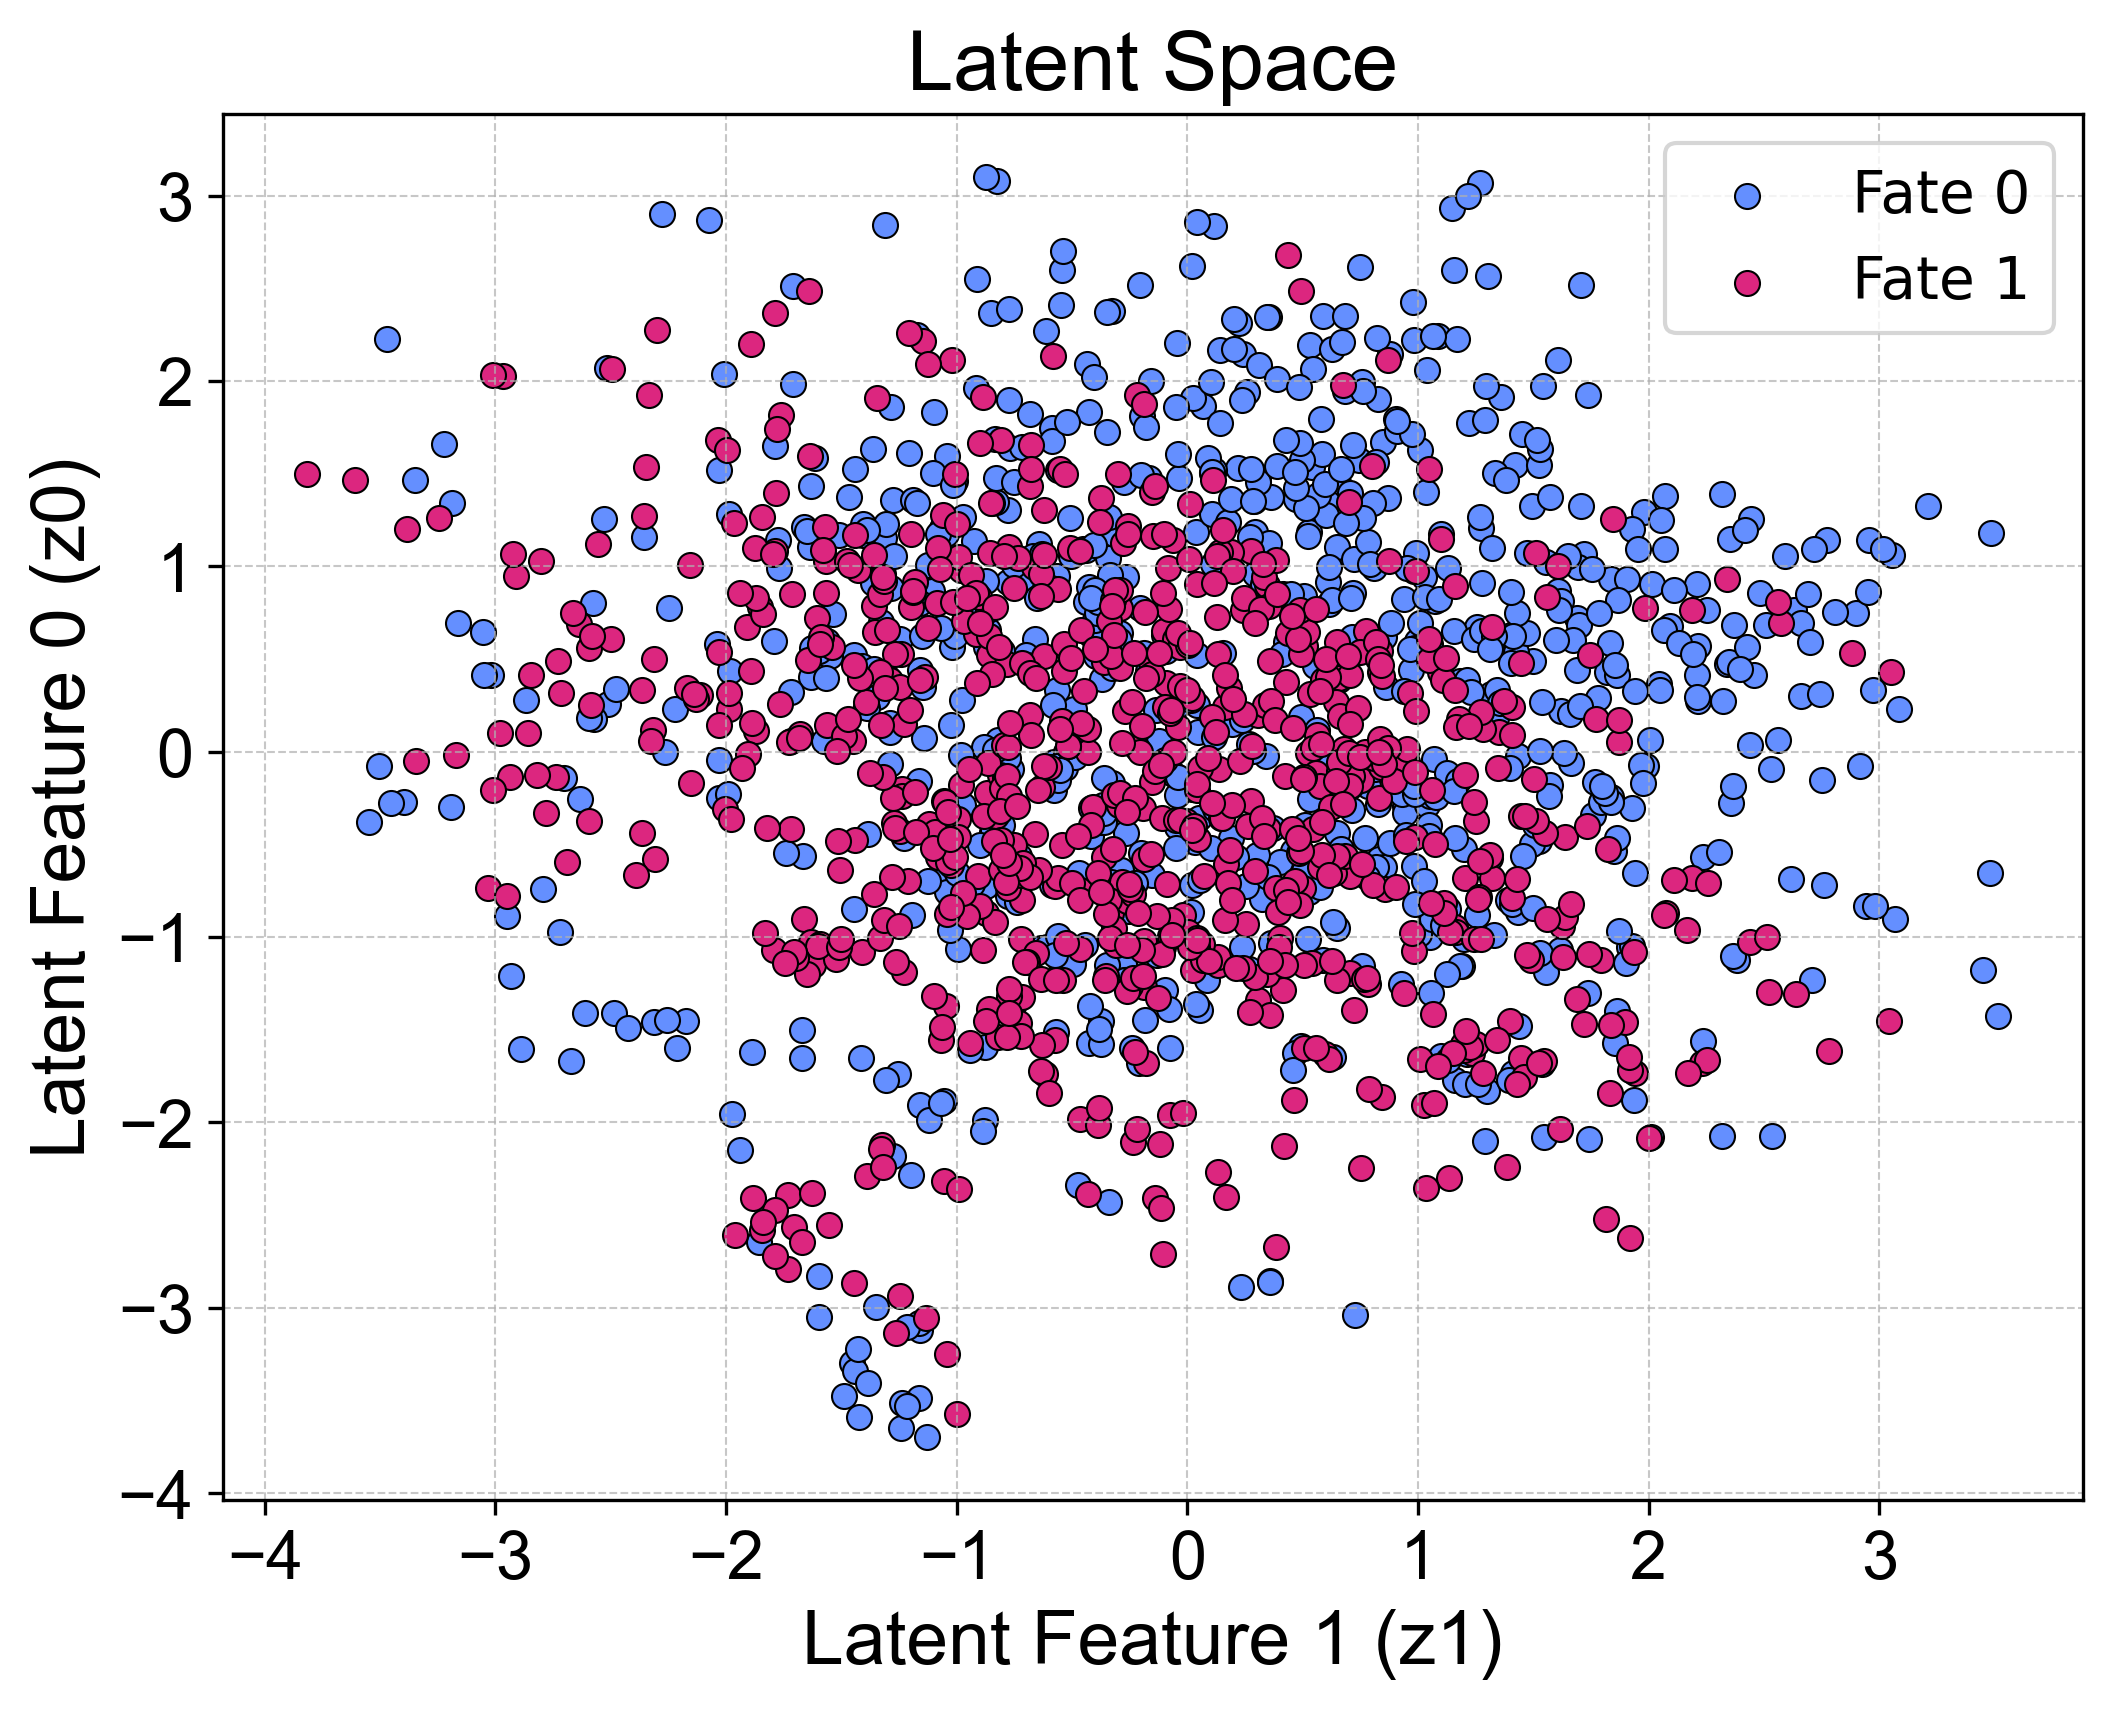

In [82]:
latent_space = encoder.predict(augmented_x_train) 
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)
feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]  # Find top 2 correlated features

print(f"Top correlated features: {feat_0}, {feat_1}")

# Scatter plot
#scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_train, cmap='viridis', alpha=0.7)
plt.figure(figsize=(8, 6), dpi=300)

plt.scatter(latent_space[y_train == 0][:, feat_0], latent_space[y_train == 0][:, feat_1], 
    color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_space[y_train == 1][:, feat_0], latent_space[y_train == 1][:, feat_1], 
    color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')
    
plt.xlabel("Latent Feature {} (z{})".format(feat_0, feat_0), fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature {} (z{})".format(feat_1, feat_1), fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
#plt.savefig("latent_space_noaug.eps", format="eps", dpi=600, bbox_inches="tight")

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


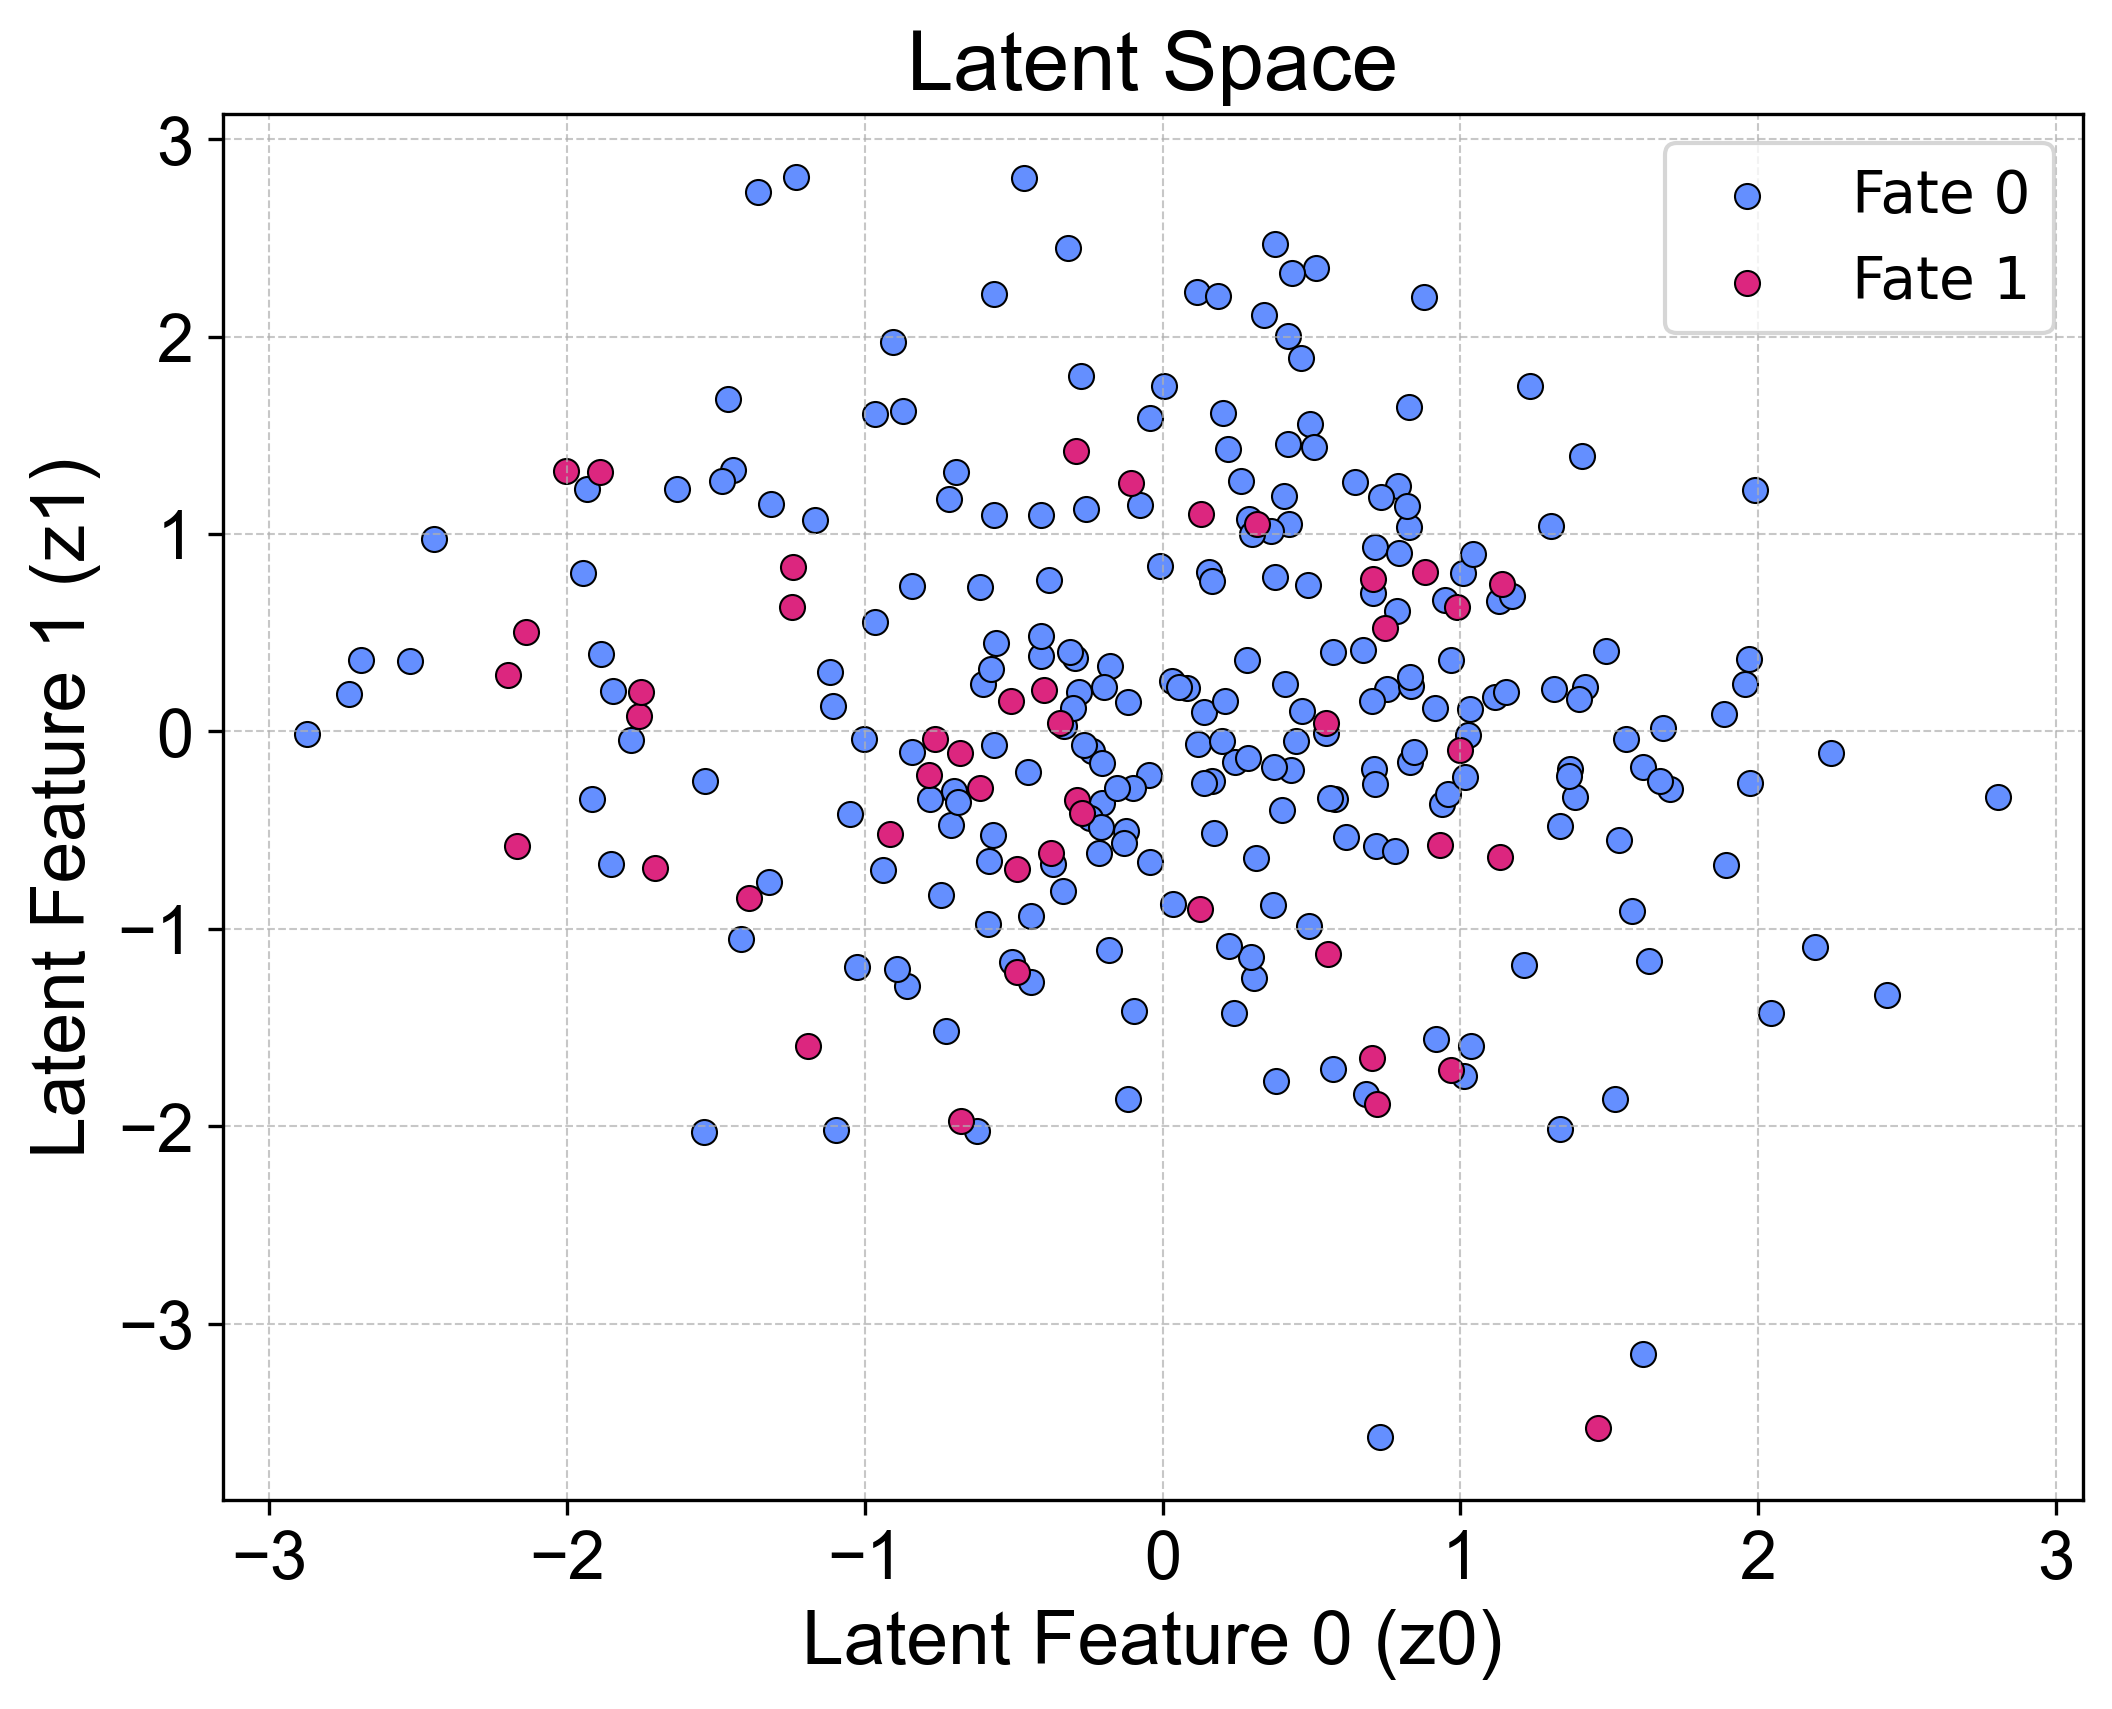

In [ ]:
# Predict the latent representations
latent_2d = encoder.predict(x_test)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_test == 0][:, 0], latent_2d[y_test == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_test == 1][:, 0], latent_2d[y_test == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-3, 4)
# plt.ylim(-3.5, 2)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_ls_noaug.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()

In [85]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_test)[y_test == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_test)[y_test == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Distance between class centroids: 0.5814


Balancing Class 0: 1392 → 270 samples (preserving augmentation structure)
✅ Balanced Class 0: 270 samples with equal augmentation representation
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


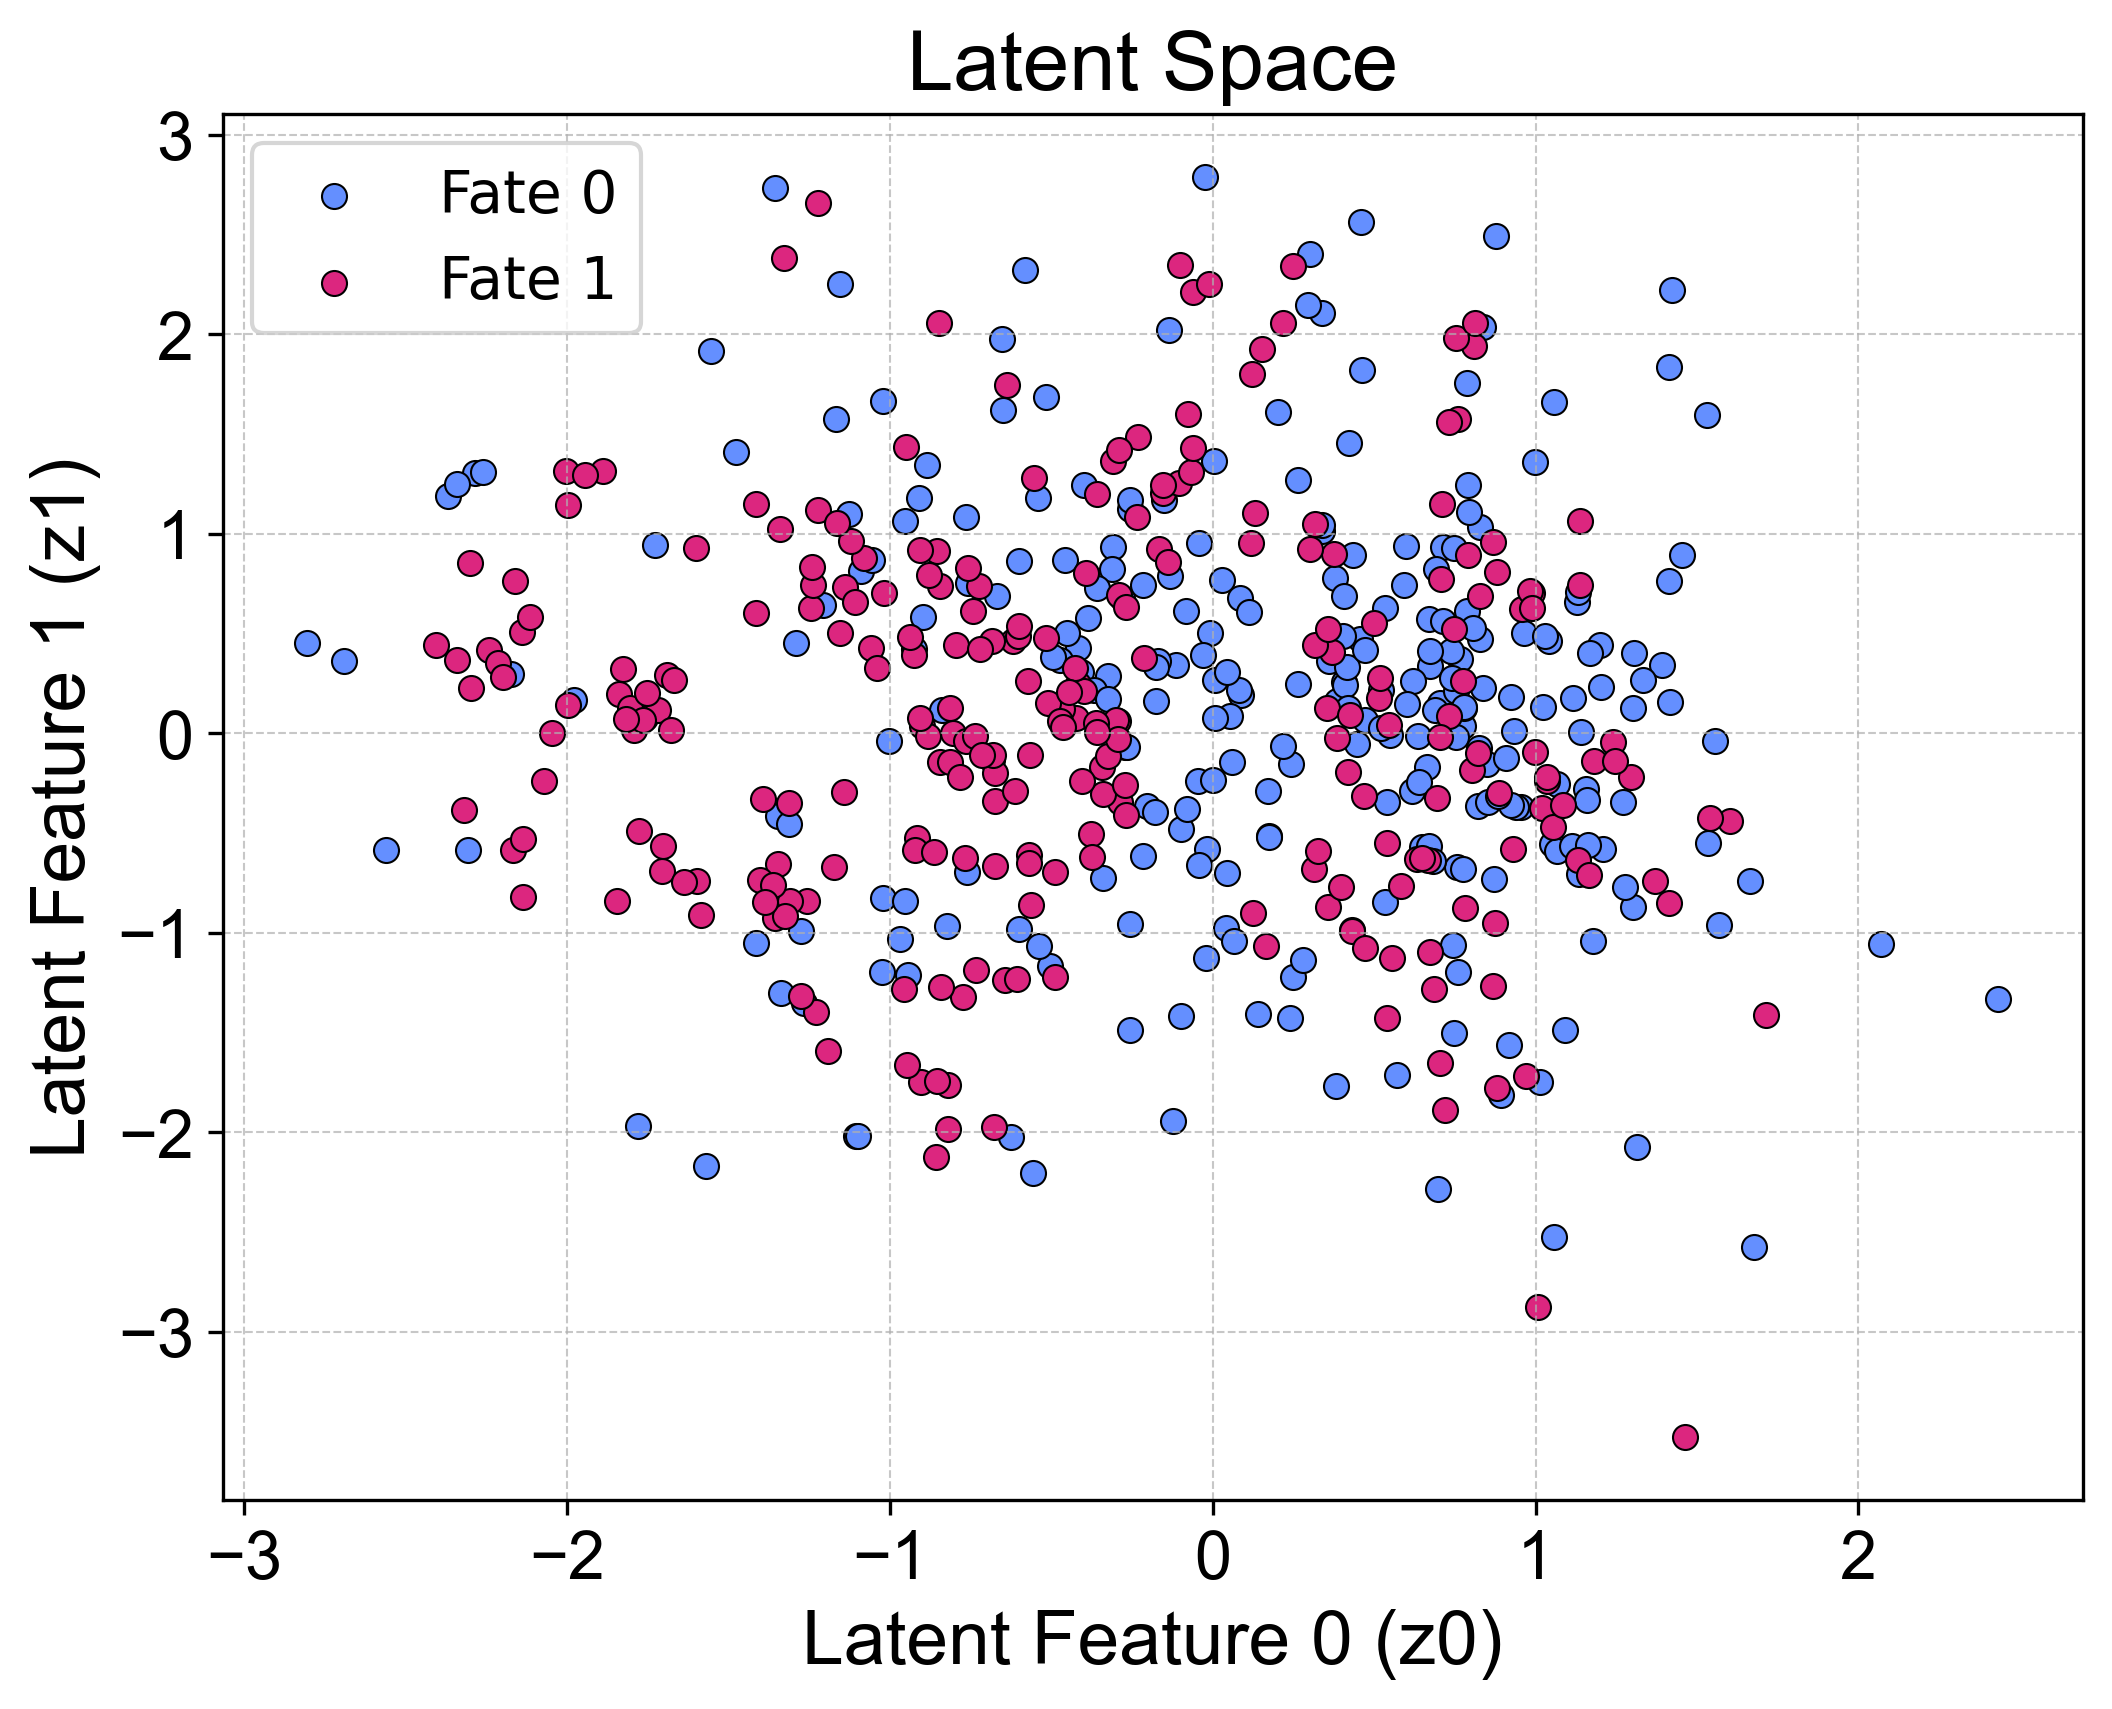

In [ ]:
#### latent space correctly saved
from src.preprocessing.preprocessing_functions import *

augmented_x_test_for_visuals, augmented_y_test_for_visuals = augment_dataset(x_test, y_test, augmentations)

# Predict the latent representations
latent_2d = encoder.predict(augmented_x_test_for_visuals)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[augmented_y_test_for_visuals == 0][:, 0], latent_2d[augmented_y_test_for_visuals == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[augmented_y_test_for_visuals == 1][:, 0], latent_2d[augmented_y_test_for_visuals == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-3, 2)
# plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')
    
# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_ls_aug.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()


In [87]:
from scipy.spatial.distance import euclidean
# Compute centroids
centroid_class_0 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Distance between class centroids: 0.5608


# Get final confusion matrices

In [20]:
cm_seed42 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc0_lcon0/confusion_matrix_values_epoch_99.npy")
cm_seed43 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc0_lcon0/confusion_matrix_values_epoch_99.npy")
cm_seed44 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la0_seed44_ldim2_s2_lr6_la0_lc0_lcon0/confusion_matrix_values_epoch_99.npy")

conf_matrix = np.stack([cm_seed42, cm_seed43, cm_seed44], axis=0)

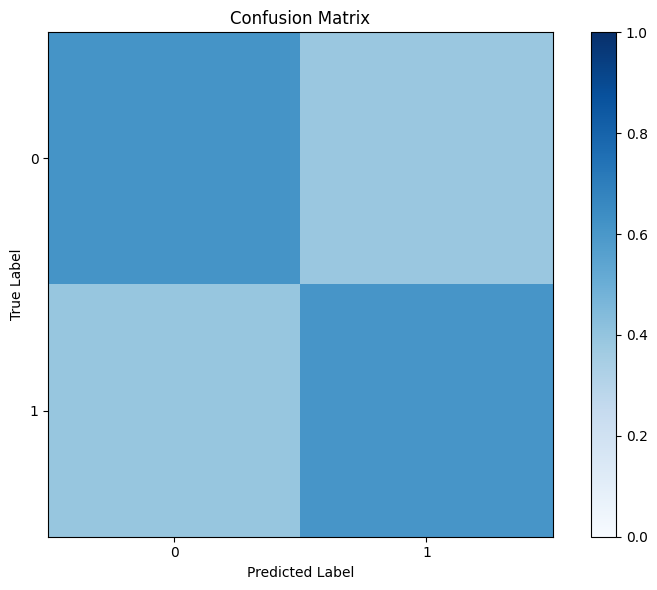

In [21]:
mean_conf_matrix = np.mean(conf_matrix,axis=0)
num_classes = 2
plt.figure(figsize=(8, 6))
plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

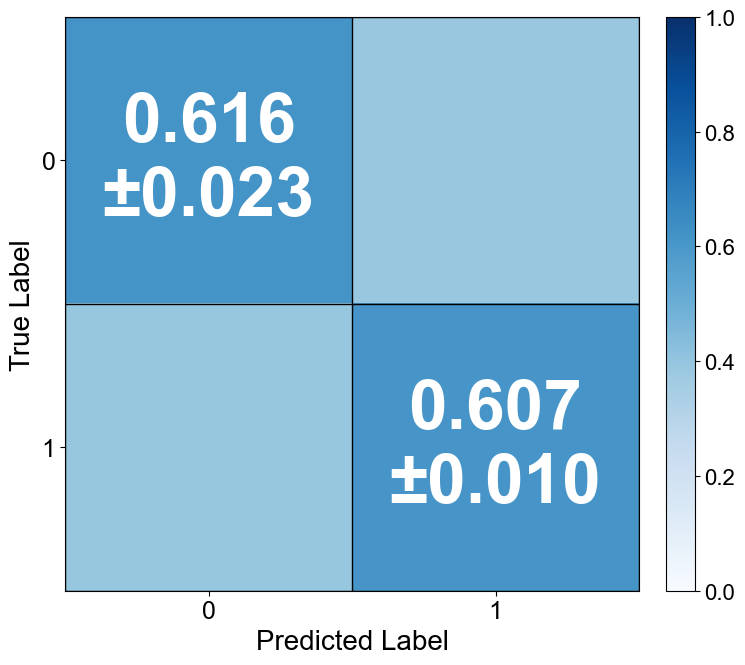

In [ ]:
# Annotated mean confusion matrix with ± std (across 3 seeds)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix, axis=0)
std_cm = np.std(conf_matrix, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
#ax.set_title('Non-Engineered Latent Space: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("non_engineered_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()